# Snapshot Ensembles experiments

Let's build an ensemble of models for MNIST classification problem. For building an ensemble we use concept 'Train 1, get M for free', described in the [paper](https://arxiv.org/abs/1704.00109)

![title](http://ipic.su/img/img7/fs/1.1507631798.png)

In standard practice the model converges to a minimum at the end of training (left figure).

In snapshot ensemble concept the model undergoes several learning rate annealing cycles, converging to and escaping from multiple local minima. We take a snapshot at each minimum for test-time ensembling (right figure).

In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt

import os
import blosc

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

sys.path.append("..")

from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from ensemble_resnet_batch import MnistBatch
from ensemble_resnet_batch import draw_stats

Load MNIST data

In [3]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

# LEN_MNIST = 65000
# indy = DatasetIndex(np.arange(LEN_MNIST))

# mnistset = Dataset(indy, batch_class=MnistBatch)
# mnistset.cv_split([0.9, 0.1])

ix = DatasetIndex(range(58500))
train_dataset = Dataset(ix, MnistBatch)


In [4]:
len(train_dataset)

58500

We train one model for 2000 iterations with cyclic learning rate:

\begin{align}
\alpha(t) = \frac{\alpha_0}{2} \left( \cos \left( \frac{\pi mod(t-1, [T/M])}{[T/M]} \right) + 1 \right) \in [\alpha_0, 0]
\end{align}

And save 4 snapshot models at each minimum of learning rate

In [7]:
alpha = 0.1
period = 400
n_iterations = 1601

In [8]:
config = {'resnet':{'period':period, 'n_iterations':n_iterations, 'alpha':alpha}}

In [ ]:
stats = []
loss_history = []
train_accs = []
train_loss_history = []

In [9]:
# pipeline for train
ppl = (train_dataset.pipeline(config=config).
       train_res(train_loss_history, train_accs, src[0][:58500], full_labs[:58500]))

# # pipeline for test
# ppl_test = (mnistset.test.pipeline().
#             load(src=src, fmt='ndarray').
#             update_stats(sess, stats, loss_history))

In [ ]:
for i in tqdm(range(n_iterations)):
    ppl.next_batch(100, n_epochs=None, shuffle=2)
    if i % 50 == 0:
        print(i, 'current stat', train_accs[-10:])

Accuracy on train

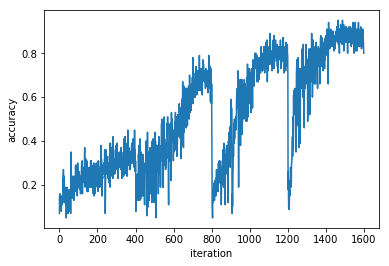

In [11]:
draw_stats(train_accs, '')

Loss on train

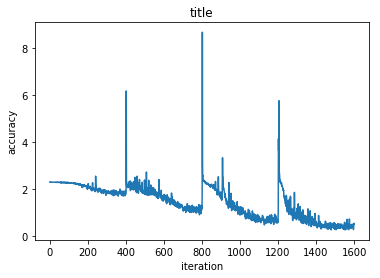

In [12]:
plt.title('title')
plt.plot(train_loss_history[:] )
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

Для получения результатов ансамбля $m$ моделей, загрузим сохраненные модели и усредним выходы $softmax$ слоев каждой модели
To get 

In [13]:
ix_test = DatasetIndex(range(65000 - 58500))
test_dataset = Dataset(ix_test, MnistBatch)

In [14]:
ensemble_stats = []
ensemble_loss_history = []

# pipeline for ensemble test
ppl_ens_test = (test_dataset.pipeline(config).
            update_stats_ensemble(config, ensemble_stats, ensemble_loss_history, src[0][58500:], src[1][58500:]))

In [15]:
for i in tqdm(range(65)):
    ppl_ens_test.next_batch(100, n_epochs=None)

currently loading trained+400/model-400.meta
INFO:tensorflow:Restoring parameters from trained+400/model-400
currently loading trained+800/model-800.meta
INFO:tensorflow:Restoring parameters from trained+800/model-800
currently loading trained+1200/model-1200.meta
INFO:tensorflow:Restoring parameters from trained+1200/model-1200
currently loading trained+1600/model-1600.meta
INFO:tensorflow:Restoring parameters from trained+1600/model-1600



В итоге лосс ансамбля моделей (исключая 400-ую итерацию) (после красной черты) не улучшает результат финальной модели:

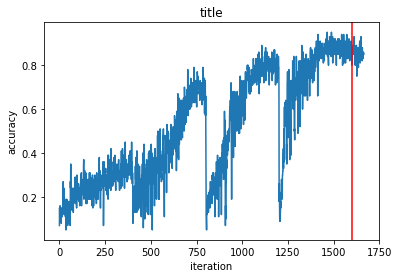

In [19]:
plt.title('title')
plt.plot(train_accs + ensemble_stats)
plt.axvline(x=1601, c='r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

In [ ]:
Это заметно по скачку loss-

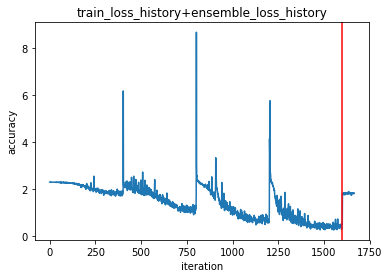

In [23]:
plt.title('train_loss_history+ensemble_loss_history')
plt.plot(train_loss_history + ensemble_loss_history)
plt.axvline(x=1601, c='r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

Вопреки ожиданиям усреднение нескольких глобальных минимумов не улучшило, а напротив, ухудшило результат. Думаю, стоит попробовать другой способ агрегирования результатов нескольких моделей (например, максимум).
